# Import and display the abalone dataset

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as pt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import root_mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, RandomizedSearchCV

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
cols = ["Sex", "Length", "Diameter", "Height",
        "Whole_weight", "Shucked_weight",
        "Viscera_weight", "Shell_weight", "Rings"]
abalone = pd.read_csv(url, names=cols)
abalone.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# Multiple linear regression

In multiple linear regression, we have multiple predictors, i.e. multiple independent variables $x_1,x_2,\ldots$. For two predictors the model can be something like this

$$y(x) = \beta_0 + \beta_1 x_1 + \beta_2 x_2$$

and "fitting" means finding the best values for the parameters $\beta_0$ (intercept) and $\beta_j$s.

This model assumes a linear relationship between the independent variables $x_j$ and a dependent variable $y$.

The independent variables can exhibit interaction which also needs to be considered. For example the following model can be used for two independent variables

$$y(x) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 \cdot x_2$$

## Assumptions

Each data point $i$ is modeled as

$$y_i = \beta_0 + \beta_j x_{ji} + e_i$$

#### Assumptions

The main assumption is a **linear** relationship between $x_j$ and $y$.

It also makes the following assumptions on the error terms:

* **Homoscedasticity**: the errors $e_i$ have the same variance $\sigma^2$ (independent of $x$)


* **Independence**: the errors $e_i$ are independent.


* **Normality**: the errors are normally distributed (not necessary for calculating estimates of $\beta_j$, but important for hypothesis tests and confidence intervals).

*checked later*

## Step 1: Explore the dataset

In [2]:
# Amount of samples per sex
abalone.describe(include='all')
abalone['Sex'].value_counts()

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64

Mean Rings: 9.933684462532918
Median Rings: 9.0
Std Rings: 3.2241690320681284


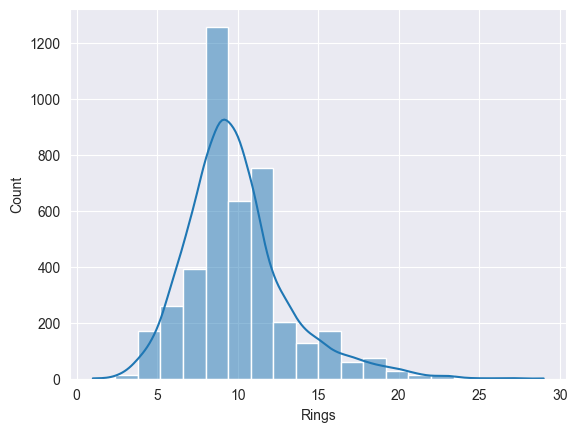

In [3]:
# Distribution of the target variable (Rings)
sns.histplot(abalone['Rings'], kde=True, bins=20)

print("Mean Rings:", abalone['Rings'].mean())
print("Median Rings:", abalone['Rings'].median())
print("Std Rings:", abalone['Rings'].std())


In [4]:
fig = px.scatter_matrix(abalone, width=1000, height=1000, color="Diameter")
fig.show()

In [5]:
fig = px.scatter_matrix(abalone, width=1000, height=1000, color="Shell_weight")
fig.show()

In [6]:
fig = px.scatter_matrix(abalone, width=1000, height=1000, color="Sex")
fig.show()

In [7]:
fig = px.scatter(abalone, x='Shell_weight', y='Rings', color='Sex', width=500, height=300)
fig.show()

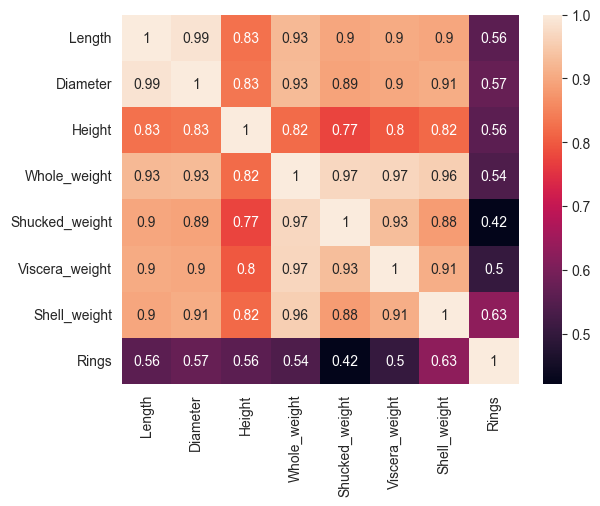

In [8]:
correlation = abalone.drop(columns=["Sex"]).corr()
heatmap = sns.heatmap(correlation, annot=True)
pt.show()

## First impressions on features

- The `Sex` feature is categorical, has three values: M, F, and I (infant) and has an impact on the target variable `Rings` which makes sense as the age of abalones is related.
- `Length`, `Diameter`, and `Height` are continuous features which highly correlate with each other which also makes sense as they are physical dimensions of the abalones.
- `Whole_weight`, `Shucked_weight`, `Viscera_weight`, and `Shell_weight` are also continuous features that correlate with each other and the dimension features.

To avoid multicollinearity, we have to be careful when selecting the features for our model. We can either select one feature from each group of highly correlated features or use dimensionality reduction techniques like PCA.

In a first approach it would make sense to use `Shell_weight` as it has the highest correlation with the target variable `Rings` and is a good representative of the physical characteristics of abalones.


## Step 2: Find the best model

In [9]:
abalone["log_Rings"] = np.log2(abalone["Rings"])
abalone["log_Shell_weight"] = np.log2(abalone["Shell_weight"])

model = smf.ols(formula="log_Rings ~ log_Shell_weight", data=abalone)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_Rings   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     5041.
Date:                Mon, 16 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:43:44   Log-Likelihood:                -1037.8
No. Observations:                4177   AIC:                             2080.
Df Residuals:                    4175   BIC:                             2092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.9422      0.011  

### Another approach with multiple features

In [10]:
abalone["log_Length"] = np.log2(abalone["Length"])
abalone["log_Shell_weight"] = np.log2(abalone["Shell_weight"])
dummy_abalone = pd.get_dummies(abalone, columns=["Sex"], drop_first=True)

formula = ("log_Rings ~ log_Length + log_Shell_weight "
           "+ Sex_M + Sex_I "
           "+ log_Length:Sex_M + log_Length:Sex_I")

results = smf.ols(formula, data=dummy_abalone).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_Rings   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     1001.
Date:                Mon, 16 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:43:44   Log-Likelihood:                -827.87
No. Observations:                4177   AIC:                             1670.
Df Residuals:                    4170   BIC:                             1714.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Conclusion

The approach with multiple features worked slightly better.
- `Length` has a negative impact on `Rings`
- The effect from `Length` on `Rings` is most negative for females
- `Shell_weight` stays strong feature
- `Sex` alone is not significant, but in combination with `Length` its better

Both approaches are moderately good. In both approaches the values for Omnibus, JB, Skew and Kurtosis indicate non-normally distributed residuals.

## Step 2: Validity of the model

*see assumptions above*

In the following code i will check the main assumptions for my multiple linear regression model.

### Normality of residuals

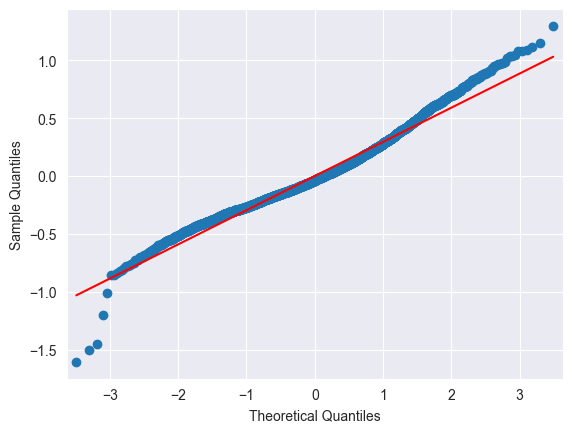

In [11]:
fig = sm.qqplot(results.resid.sort_values(), dist=stats.norm, line='s')

In [12]:
from scipy import stats

shapiro_stat, shapiro_p = stats.shapiro(results.resid)
if shapiro_p > 0.05:
    print(f"Shapiro-Wilk: p = {shapiro_p:.3f} -> normality plausible")
else:
    print(f"Shapiro-Wilk: p = {shapiro_p:.3f} -> not normality plausible")

dagostino_stat, dagostino_p = stats.normaltest(results.resid)
if dagostino_p > 0.05:
    print(f"D’Agostino-Pearson: p = {dagostino_p:.3f} -> normality plausible")
else:
    print(f"D’Agostino-Pearson: p = {dagostino_p:.3f} -> not normality plausible")

anderson_result = stats.anderson(results.resid)
sig_levels = anderson_result.significance_level
crit_values = anderson_result.critical_values
statistic = anderson_result.statistic

index_5 = sig_levels.tolist().index(5.0)
crit_5 = crit_values[index_5]

if statistic < crit_5:
    print(f"Anderson-Darling: stat = {statistic:.3f} < crit @5% = {crit_5:.3f} -> normality plausible")
else:
    print(f"Anderson-Darling: stat = {statistic:.3f} ≥ crit @5% = {crit_5:.3f} -> not normality plausible")


Shapiro-Wilk: p = 0.000 -> not normality plausible
D’Agostino-Pearson: p = 0.000 -> not normality plausible
Anderson-Darling: stat = 30.111 ≥ crit @5% = 0.786 -> not normality plausible


The Q-Q plot shows some stronger deviation on both ends.

All 3 Tests indicate no normality of the residuals which leads to bad/moderate performance and also violates the normality assumption.

### Homoscedasticity


In [13]:
df = abalone
df['fitted'] = results.predict()
df['residuals'] = results.resid

fig = px.scatter(abalone, x='fitted', y='residuals', marginal_y='box')
fig.update_layout(
    title="Residuals vs fitted values",
    yaxis_title="residuals",
    xaxis_title="modelled values",
    font=dict(
        family="Lucida Sans, monospace",
        size=18,
        color="#7f7f7f"
    )
)

The scatter plot show som slight outliers.


In [14]:
bp = het_breuschpagan(results.resid, results.model.exog)
print(f"Breusch-Pagan p-value: {bp[3]:.4f}")
white = het_white(results.resid, results.model.exog)
print(f"White p-value: {white[1]:.4f}")

Breusch-Pagan p-value: 0.0000
White p-value: 0.0000


Since Breusch-Pagan and White Test are both below 5% i can say, that the variance is not constant which also violates the Homoscedasticity assumption.

### Independence

In [15]:
print(f"Durbin-Watson: {durbin_watson(results.resid):.3f}")

Durbin-Watson: 1.229


As already seen in the ols summary; durbin-watson is below 1.5 which indicates some autocorrelation. (which ofcourse makes sense)

Therefore also the independence assumption is violated.

### More Assumptions (for good measure)

In [16]:
# multicollinearity
X = abalone[["Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera_weight", "Shell_weight"]]
vif_df = pd.DataFrame({
    'variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif_df)

         variable         VIF
0          Length  695.083714
1        Diameter  748.879248
2          Height   42.117537
3    Whole_weight  421.579746
4  Shucked_weight  101.575906
5  Viscera_weight   63.348265
6    Shell_weight   81.772105


Insanely strong multicollinearity in all features. (This was already indicated by the correlation matrix.

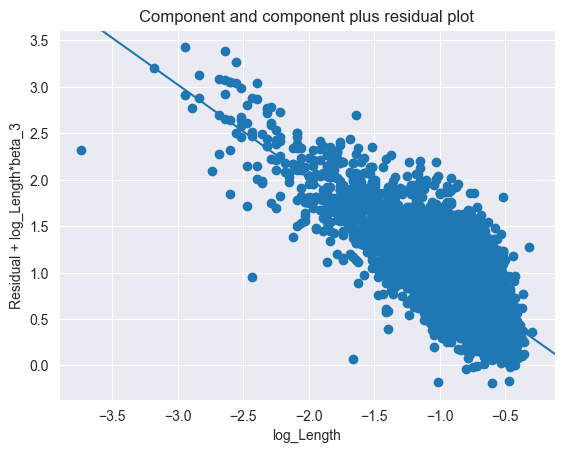

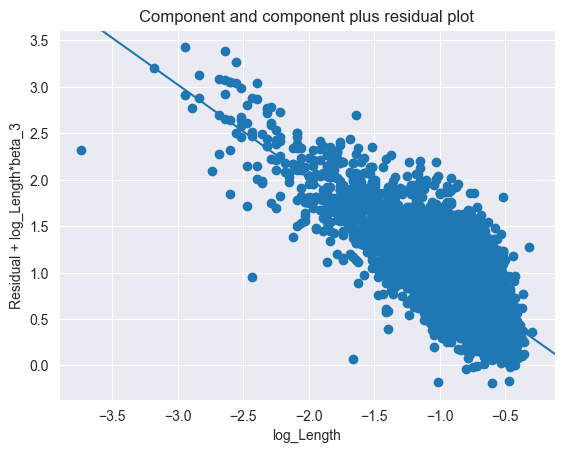

In [17]:
sm.graphics.plot_ccpr(results, 'log_Length')

The scatter shows a moderate linearity but also some exotic datapoints and a possible variance inequality.

In [18]:
influence = results.get_influence()
cook_d, _ = influence.cooks_distance
print(f"Max Cook’s D: {cook_d.max():.3f}")


Max Cook’s D: 0.238


D value shows some strong impact.

## Conclusion

The final multiple‐linear‐regression model explains part of the variation in **Rings**, but almost all classical OLS
assumptions are violated, so the model cannot be trusted for inference:

* **Normality of residuals** – Shapiro–Wilk, D’Agostino–Pearson and Anderson–Darling all yield *p < 0.001*; the QQ‑plot shows heavy tails.
* **Homoscedasticity** – Breusch–Pagan and White tests reject $H_0$ (both *p $\approx$ 0*); residual–vs–fitted scatter reveals a funnel pattern.
* **Independence** – Durbin–Watson = 1.23 (< 1.5) indicates positive autocorrelation.
* **Multicollinearity** – VIFs go from 42 up to > 700; coefficients are unstable.
* **Influential observations** – Cook’s D identifies several highly influential points.

Because at least four key assumptions fail, the current OLS models *t*‑, *F*‑ and confidence‑interval statistics are unreliable and its predictions are likely biased/inefficient.

**Suggested next steps**

1. Remove or combine highly collinear variables (or use PCA, Ridge, or Lasso).
2. Apply variance‑stabilising transforms (e.g. Box‑Cox) or switch to a GLM with an appropriate distribution.
3. Address autocorrelation
4. etc.

As requested in the exersice, I will now try other regressors (rings as continuous) from well known libraries. (Including a LinearRegression model from sckit)

# Other Regressors

Prepare features and target variable.

In [19]:
# fresh reload
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
cols = ["Sex", "Length", "Diameter", "Height",
        "Whole_weight", "Shucked_weight",
        "Viscera_weight", "Shell_weight", "Rings"]
abalone = pd.read_csv(url, names=cols)

X = abalone.drop("Rings", axis=1)
y = abalone["Rings"]

X.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


Encode categorial variable. In this case `Sex`.

In [20]:
categorical_features = ["Sex"]
numeric_features = X.columns.drop("Sex")

numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


Split to test and train split.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define Parameter-Grids and Regressors

In [22]:
param_grids = {
    "LinearRegression": {
        "regressor__fit_intercept": [True, False],
    },
    "Ridge": {
        "regressor__alpha": [0.1, 1, 10, 100]
    },
    "Lasso": {
        "regressor__alpha": [0.001, 0.01, 0.1, 1]
    },
    "SVR": {
        "regressor__kernel": ["rbf"],
        "regressor__C": [1, 10, 100],
        "regressor__gamma": ["scale", 0.01, 0.001]
    },
    "RandomForest": {
        "regressor__n_estimators": [300, 600, 900],
        "regressor__max_depth": [None, 10, 20],
        "regressor__min_samples_split": [2, 5, 10],
        "regressor__min_samples_leaf": [1, 3],
        "regressor__max_features": ["sqrt", 0.5],
        "regressor__bootstrap": [True, False],
        "regressor__max_samples": [0.75, 1.0]
    },
    "GradientBoosting": {
        "regressor__n_estimators": [300, 600, 900],
        "regressor__learning_rate": [0.03, 0.05, 0.1],
        "regressor__max_depth": [2, 3],
        "regressor__subsample": [0.6, 0.8, 1.0],
        "regressor__min_samples_split": [2, 5],
        "regressor__min_samples_leaf": [1, 3],
        "regressor__max_features": ["sqrt", 0.5],
        "regressor__loss": ["squared_error", "huber"]
    }
}
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42, max_iter=10000),
    "SVR": SVR(),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}



Train and test all regressors with RandomizedSearchCV cross-validation.

In a first try i used GridSearch, but after extending the hyperparameter-grid the trainingtime was way too long.

In [23]:
outer_results = {}

for name, estimator in models.items():
    pipe = Pipeline([
        ("prep", preproc),
        ("regressor", estimator)
    ])

    gs = RandomizedSearchCV(
        estimator=pipe,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        param_distributions=param_grids[name],
    )
    gs.fit(X_train, y_train)

    y_pred = gs.best_estimator_.predict(X_test)
    outer_results[name] = {
        "RMSE_test": root_mean_squared_error(y_test, y_pred),
        "R2_test": r2_score(y_test, y_pred),
        "best_params": gs.best_params_
    }

results_df = (
    pd.DataFrame(outer_results)
    .T.sort_values("RMSE_test")
)

print(results_df)


C:\Users\Luca\IdeaProjects\_bfh\mmde\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning:

The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.

C:\Users\Luca\IdeaProjects\_bfh\mmde\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\Luca\IdeaProjects\_bfh\mmde\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.

C:\Users\Luca\IdeaProjects\_bfh\mmde\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\Luca\IdeaProjects\_bfh\mmde\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning:

The total space 

                 RMSE_test   R2_test  \
SVR               2.170752  0.564705   
RandomForest      2.185743  0.558672   
Ridge             2.211589  0.548173   
LinearRegression  2.211613  0.548163   
Lasso             2.211881  0.548053   
GradientBoosting    2.2209   0.54436   

                                                        best_params  
SVR               {'regressor__kernel': 'rbf', 'regressor__gamma...  
RandomForest      {'regressor__n_estimators': 600, 'regressor__m...  
Ridge                                       {'regressor__alpha': 1}  
LinearRegression                {'regressor__fit_intercept': False}  
Lasso                                   {'regressor__alpha': 0.001}  
GradientBoosting  {'regressor__subsample': 0.8, 'regressor__n_es...  


## Comparison

* **The own OLS is best; but:** – the 0.59 $R^2$ is in-sample and on a log scale; on an unseen test set and back-transformed to rings its $R^2$ should drop a bit bringing it in line with the 0.55-0.56 range of the ML models.
* **SVR and Random Forest are effective** Their 0.015 RMSE gap equals \~0.02 years of age – practically negligible given the ±2.2 year error band. They actually improved from extending the hyperparameters grid with more estimators.
* **Linear baselines remain strong.** Ridge/Lasso lose only by \~0.03 $R^2$.
* All models hit a predictive ceiling around 56 % explained variance, signaling either measurement noise (ring counts) or missing predictors (e.g., habitat, temperature).


## Take-away

For pure prediction accuracy i can use the SVR (or the nearly identical Random Forest). For explainability and easier deployment a Ridge regression is almost as accurate and far simpler to interpret. Either way,i expect an inevitable around 2-year age error. A limitation of the dataset rather than the algorithm.


# Classification

<Axes: xlabel='Rings', ylabel='Count'>

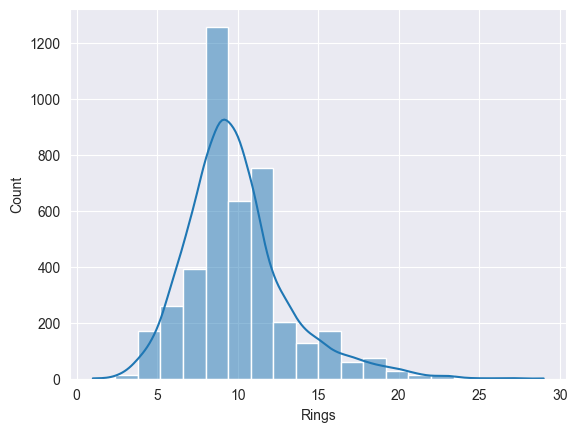

In [24]:
sns.histplot(abalone['Rings'], kde=True, bins=20)

Based on the `Rings` distribution i've decided to predict the following classes:

- $\leq 7$
- $8-9$
- $10-11$
- $\geq 12$

to be more granular than with binary or quantiles classes.

In the following cell i cut the target variables in those four classes.

In [25]:
bins   = [0, 7, 9, 11, np.inf]
labels = ["<=7", "8-9", "10-11", ">=12"]

y_class = pd.cut(
    y,
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)
print(y_class.value_counts(normalize=True))

Rings
8-9      0.300934
10-11    0.268374
>=12     0.229830
<=7      0.200862
Name: proportion, dtype: float64


Train/Test split based on the predefined classed

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_class,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)

Define hyperparameters grid and classifiers

In [27]:
models = {
    "LogReg": LogisticRegression(max_iter=500, class_weight="balanced"),
    "SVC": SVC(),
    "RF": RandomForestClassifier(n_jobs=-1, class_weight="balanced"),
    "GB": GradientBoostingClassifier()
}

param_dists = {
    "LogReg": {
        "regressor__C": np.logspace(-3, 3, 20),
        "regressor__penalty": ["l2", "l1"],
        "regressor__solver": ["liblinear", "lbfgs"]
    },
    "SVC": {
        "regressor__C": np.logspace(-2, 2, 20),
        "regressor__kernel": ["rbf"],
        "regressor__gamma": ["scale", 0.01, 0.001]
    },
    "RF": {
        "regressor__n_estimators": [300, 600, 900],
        "regressor__max_depth": [None, 10, 20],
        "regressor__min_samples_leaf": [1, 3],
        "regressor__max_features": ["sqrt", 0.5],
        "regressor__bootstrap": [True, False]
    },
    "GB": {
        "regressor__n_estimators": [300, 600, 900],
        "regressor__learning_rate": [0.03, 0.05, 0.1],
        "regressor__max_depth": [2, 3],
        "regressor__subsample": [0.6, 0.8, 1.0],
        "regressor__loss": ["log_loss", "deviance"]
    }
}

Run RandomizedSearchCV on grid

In [28]:
outer_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, estimator in models.items():
    pipe = Pipeline([
        ("prep", preproc),
        ("regressor", estimator)
    ])

    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dists[name],
        cv=cv,
        n_iter=50,
        n_jobs=-1,
        scoring="f1_macro",
        random_state=42
    )
    search.fit(X_train, y_train)

    y_pred = search.best_estimator_.predict(X_test)
    outer_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1_macro": f1_score(y_test, y_pred, average="macro"),
        "best_params": search.best_params_
    }

results_df = (
    pd.DataFrame(outer_results)
    .T.sort_values("F1_macro", ascending=False)
)
print(results_df)


C:\Users\Luca\IdeaProjects\_bfh\mmde\venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning:


50 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Luca\IdeaProjects\_bfh\mmde\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Luca\IdeaProjects\_bfh\mmde\venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Luca\IdeaProjects\_bfh\mmde\venv\Lib\site-package

        Accuracy  F1_macro                                        best_params
RF      0.590909  0.604446  {'regressor__n_estimators': 300, 'regressor__m...
SVC     0.588517  0.602133  {'regressor__kernel': 'rbf', 'regressor__gamma...
GB      0.582536  0.594018  {'regressor__subsample': 0.6, 'regressor__n_es...
LogReg  0.557416  0.565608  {'regressor__solver': 'lbfgs', 'regressor__pen...


## Interpretation and Conclusion

- Ofcourse the classes are slightly imbalanced which might have an impact on models which ignore class balance
- In terms of accuracy SVC is ahead since it dominates the two middle classes but macro-f1 punishes it for mising the tails; RandomForest is ahead here.
- All models are around 0.7 macro-f1 which is decent for four uneven bins on the target variable.

I prefer the Random Forest Classifier since its the fairest performance across all classes.



# Overall conclusion

In short, all three approaches converge on the same practical limit. With the current feature set we can predict abalone age only to a coarse granularity. Good enough for rough grouping, but not for precise individual aging. Further improvement will require richer biological features rather than ever-tighter model tuning.
